<a href="https://colab.research.google.com/github/xslittlemaggie/Deep-Learning-Projects/blob/master/Steel%20Defect%20Detection_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Part 0: Import libraries

In [0]:
from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image

# graphs
% matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 15
import seaborn as sns
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
from collections import defaultdict
from pathlib import Path
import random
import cv2
import os
import glob
import urllib.request


Using TensorFlow backend.


## Part 1: Upload data

#### 1. upload data from Kaggle

In [0]:
os.environ['KAGGLE_USERNAME'] = "maggie" # username from the json file 
os.environ['KAGGLE_KEY'] = "7adfc6c4e6c5eec087031fbb7397aee" # key from the json file (This key is incorrect5)

In [0]:
!pip install -q kaggle
!kaggle competitions download -c severstal-steel-defect-detection -p /content/

  0% 0.00/6.91M [00:00<?, ?B/s]
100% 6.91M/6.91M [00:00<00:00, 113MB/s]
  0% 0.00/141k [00:00<?, ?B/s]
100% 141k/141k [00:00<00:00, 150MB/s]
100% 1.16G/1.16G [00:08<00:00, 152MB/s]
100% 1.16G/1.16G [00:08<00:00, 143MB/s]
 93% 120M/129M [00:00<00:00, 122MB/s]
100% 129M/129M [00:01<00:00, 125MB/s]


In [0]:
!unzip -q /content/train.csv.zip -d /content/train.csv/
!unzip -q /content/train_images.zip -d /content/train_images/
!unzip -q /content/test_images.zip -d /content/test_images/

In [0]:
DIRin1 = "/content"
DIRtrain = os.path.join(DIRin1,"train_images")
DIRtest = os.path.join(DIRin1,"test_images")


# save path
weights_path = os.path.join(DIRin1,"DefectDetection.h5")
history_path = os.path.join(DIRin1,"DefectDetection_history.csv")
print("DIRin1 =", os.listdir(DIRin1))


print("The size of Train images\t:",len(os.listdir("/content/train_images")))
print("The size of Test images\t\t:",len(os.listdir("/content/test_images")))

DIRin1 = ['.config', 'DefectDetection.h5', 'train.csv.zip', 'train.csv', 'submission.csv', 'sample_submission.csv', 'DefectDetection_history.csv', 'test_images', 'train_images.zip', 'train_images', 'test_images.zip', 'sample_data']
The size of Train images is 	: 12568
The size of Test images is		: 1801


#### 2. read text data

In [0]:
train_df = pd.read_csv("/content/train.csv/train.csv")
#sample_df = pd.read_csv("/content/sample_submission.csv")

In [0]:
train_df.head()

,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


In [0]:
# transform class to columns
train_df['fname'], train_df['cls'] = zip(*train_df['ImageId_ClassId'].str.split('_'))
train_df["cls"] = train_df["cls"].astype(int)
train_df = train_df.pivot(index='fname',columns='cls',values='EncodedPixels')
train_df['defects'] = train_df.count(axis=1)

In [0]:
train_df.head()

cls,1,2,3,4,defects
fname,,,,,
0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,NaN,NaN,NaN,1
00031f466.jpg,NaN,NaN,NaN,NaN,0
000418bfc.jpg,NaN,NaN,NaN,NaN,0
000789191.jpg,NaN,NaN,NaN,NaN,0
0007a71bf.jpg,NaN,NaN,18661 28 18863 82 19091 110 19347 110 19603 11...,NaN,1


In [0]:
# presence of defects in each images
no_defects_num = np.sum(train_df["defects"] == 0)
defects_num = len(train_df) - no_defects_num

print("the number of images with no defects: {}".format(no_defects_num))
print("the number of images with defects: {}".format(defects_num))

the number of images with no defects: 5902
the number of images with defects: 6666


In [0]:
# number of defects for each class
class_defects = len(train_df) - train_df.isnull().sum()
class_defects[:4]

cls
1     897
2     247
3    5150
4     801
dtype: int64

## Part 2: Visualization of the data

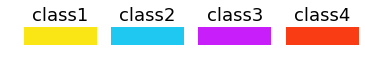

In [0]:
palet = [(250, 230, 20), (30, 200, 241), (200, 30, 250), (250,60,20)]

fig, ax = plt.subplots(1, 4, figsize=(6, 2))
for i in range(4):
    ax[i].axis('off')
    ax[i].imshow(np.ones((10, 40, 3), dtype=np.uint8) * palet[i])
    ax[i].set_title("class{}".format(i+1))

plt.show()

In [0]:
def mask2rgba(mask):
    rgba_list = []
    for idx in range(4):    # idx: class id
        rgba = cv2.cvtColor(mask[:, :, idx], cv2.COLOR_GRAY2RGBA)
        rgba[:, :, :3] = rgba[:, :, :3] /255 * palet[idx]
        rgba_list.append(rgba)
    return rgba_list

In [0]:
def make_mask(row_id):
    fname = train_df.iloc[row_id].name

    labels = train_df.iloc[row_id][:4]
    masks = np.zeros((256, 1600, 4), dtype=np.uint8)    # 4:class 1～4 (ch:0～3)

    for idx, label in enumerate(labels.values):
        if label is not np.nan:
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            mask = np.zeros(256 * 1600, dtype=np.uint8)
            for pos, le in zip(positions, length):
                mask[pos:(pos + le)] = 255
            masks[:, :, idx] = mask.reshape(256, 1600, order='F')
    return fname, masks

In [0]:
def show_mask_image(row_id, contour = True):
    name, mask = make_mask(row_id)
    img = cv2.imread(os.path.join(DIRtrain, name))

    if contour:
        for ch in range(4):
            contours, _ = cv2.findContours(mask[:, :, ch],
                            cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
            for i in range(0, len(contours)):
                cv2.polylines(img, contours[i], True, palet[ch], 2)
    else:
        for ch in range(4):
            img[mask[:,:,ch]==255] = palet[ch]
        
    fig, ax = plt.subplots(figsize=(7,7))
    ax.set_title(name)
    ax.imshow(img)
    ax.axis('off')
    plt.show()

In [0]:
# classify defects
idx_class_1 = list(filter(lambda r:not pd.isna(train_df.iloc[r,0]), range(len(train_df))))
idx_class_2 = list(filter(lambda r:not pd.isna(train_df.iloc[r,1]), range(len(train_df))))
idx_class_3 = list(filter(lambda r:not pd.isna(train_df.iloc[r,2]), range(len(train_df))))
idx_class_4 = list(filter(lambda r:not pd.isna(train_df.iloc[r,3]), range(len(train_df))))
# Nomber of defects class
idx_no_defect = list(filter(lambda r:train_df.iloc[r,4] == 0, range(len(train_df))))
idx_1_defect = list(filter(lambda r:train_df.iloc[r,4] == 1, range(len(train_df))))
idx_class_multi = list(filter(lambda r:train_df.iloc[r,4] >= 2, range(len(train_df))))

### 1. visualize the images with no defects

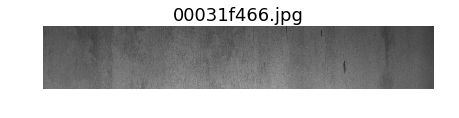

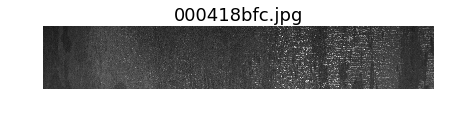

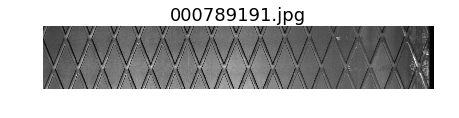

In [0]:
# no defect sumple
for idx in idx_no_defect[:3]:
    show_mask_image(idx, contour=False)

### 2. visualize the images with defects (class = 1, yellow)

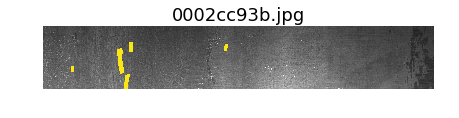

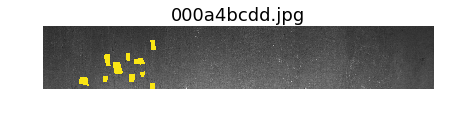

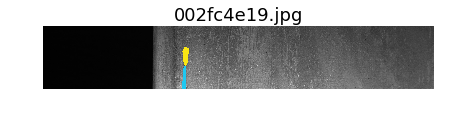

In [0]:
# class_1 defect sumple (Yellow)
for idx in idx_class_1[:3]:
    show_mask_image(idx, contour=False)

### 3. visualize the images with defects (class = 2, lighe blue)

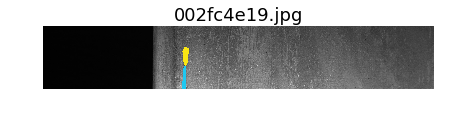

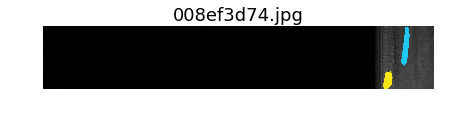

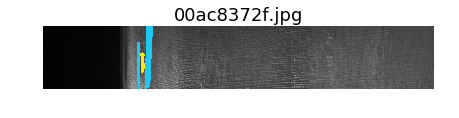

In [0]:
# class_2 defect sumple (lightblue)
for idx in idx_class_2[:3]:
    show_mask_image(idx, contour=False)

### 4. visualize the images with defects (class = 3, purple)

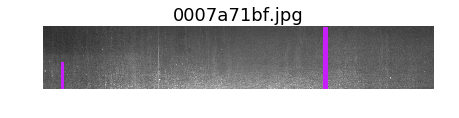

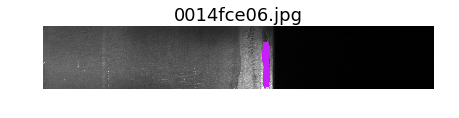

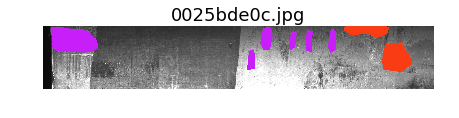

In [0]:
# class_3 defect sumple (purple)
for idx in idx_class_3[:3]:
    show_mask_image(idx, contour=False)

### 5. visualize the images with defects (class = 4, red)

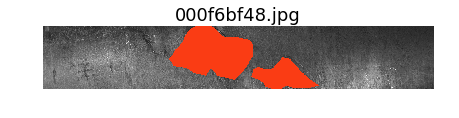

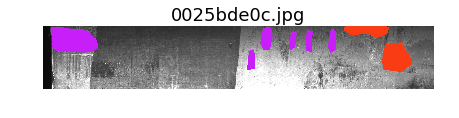

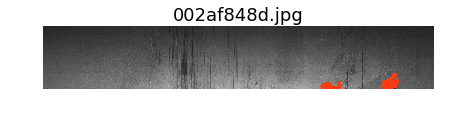

In [0]:
# class_4 defect sumple (red)
for idx in idx_class_4[:3]:
    show_mask_image(idx, contour=False)

### 6. visualize the images with multi defects

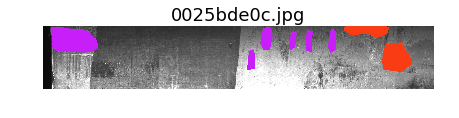

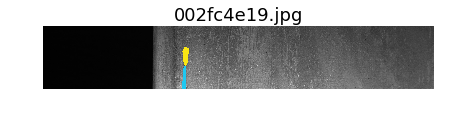

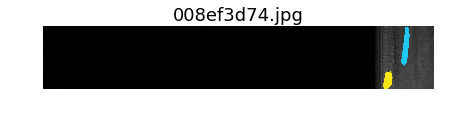

In [0]:
# contain multi class defects
for idx in idx_class_multi[:3]:
    show_mask_image(idx, contour=False)

## Part 3: Model building

### 1. Use U-Net model for object detection & segmentation

In [0]:
# U-Net
# https://www.kaggle.com/jesperdramsch/intro-chest-xray-dicom-viz-u-nets-full-data#Vanilla-Unet

input_shape = (256, 1600, 1)
inputs = Input(input_shape)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (c5)
p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (p5)
c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (c55)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
u6 = concatenate([u6, c5])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u71 = concatenate([u71, c4])
c71 = Conv2D(32, (3, 3), activation='relu', padding='same') (u71)
c61 = Conv2D(32, (3, 3), activation='relu', padding='same') (c71)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

# Load pre-traind weights
if (NoTRAIN or RESUME) and os.path.exists(weights_path):
    model.load_weights(weights_path)

model.summary()

W0821 05:23:53.206391 140317007361920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0821 05:23:53.244026 140317007361920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0821 05:23:53.252502 140317007361920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0821 05:23:53.298409 140317007361920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 1600, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 1600, 8) 80          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 1600, 8) 584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 800, 8)  0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [0]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) \
            / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [0]:
optimizer = Adam()
model.compile(optimizer, 'binary_crossentropy', metrics=[dice_coef])

W0821 05:23:53.952551 140317007361920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0821 05:23:53.960840 140317007361920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0821 05:23:53.967787 140317007361920 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### 2. training dataset & validation dataset preparation

In [0]:
##### Training conditions ##### 
batch_size = 16

NoTRAIN = True    # True:No further training, use pre-learned weights
RESUME = False    # True:Resume Training, False:Start from the beginning

if RESUME:
    initial_epoch = 50    # initial_epoch when training resumes
else:
    initial_epoch = 0
epochs = initial_epoch + 10
steps_per_epoch = 200

In [0]:
# Train Data Generator
def Xy_generator(ids, batch_size):
    Xs = []; ys = []
    while True:
        for i in ids:
            name, mask = make_mask(i)
            img = cv2.imread(os.path.join(DIRtrain, name),
                             cv2.IMREAD_GRAYSCALE)
            img = img[..., np.newaxis]    # Add channel axis
            img = img / 255.           # 0～1
            mask = mask / 255.         # 0～1
            Xs.append(img); ys.append(mask)
            if len(Xs) == batch_size:
                X = np.array(Xs); y = np.array(ys)
                Xs = []; ys = []
                yield [X, y]

In [0]:
batch_size = 16
# Train Data
train_ids, val_ids = train_test_split(range(len(train_df)), test_size=0.2)
train_gen = Xy_generator(train_ids, batch_size)
val_gen = Xy_generator(val_ids, batch_size)

X.shape: (4, 256, 1600, 1) 
y.shape: (4, 256, 1600, 4)


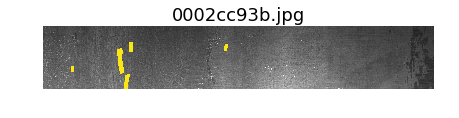

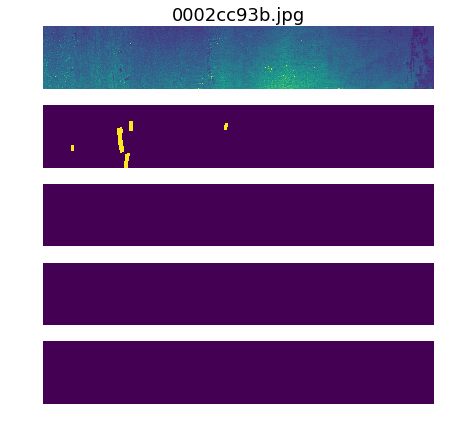

In [0]:
# generator test
for X, y in Xy_generator(range(len(train_df)), 4):
    break

print('X.shape:',X.shape, '\ny.shape:',y.shape)

row = 0
# from train_df
show_mask_image(row, contour=False)
# from generator
fig, axs = plt.subplots(5, figsize=(7,7))
axs[0].imshow(X[row,:,:,0])
axs[0].axis('off')
axs[0].set_title(train_df.iloc[row].name)
for i in range(4):
    axs[i+1].imshow(y[row,:,:,i])
    axs[i+1].axis('off')

### 3. model training/fitting

In [0]:
# Callback
checkpoint = ModelCheckpoint("DefectDetection.h5", monitor='val_dice_coef',
                             verbose=1,save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [0]:
#if NoTRAIN == False or RESUME:
history = model.fit_generator(generator=train_gen,
                              steps_per_epoch=steps_per_epoch,
                              initial_epoch=initial_epoch,
                              epochs=epochs,
                              validation_data=val_gen,
                              validation_steps = len(val_ids)//batch_size,
                              verbose=2,
                              shuffle=True,
                              callbacks=callbacks_list)

W0821 05:23:55.309688 140317007361920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/50
 - 300s - loss: 0.1799 - dice_coef: 0.0012 - val_loss: 0.1295 - val_dice_coef: 6.8213e-06

Epoch 00001: val_dice_coef improved from -inf to 0.00001, saving model to DefectDetection.h5
Epoch 2/50
 - 284s - loss: 0.1228 - dice_coef: 7.0683e-06 - val_loss: 0.1295 - val_dice_coef: 6.8786e-06

Epoch 00002: val_dice_coef improved from 0.00001 to 0.00001, saving model to DefectDetection.h5
Epoch 3/50
 - 285s - loss: 0.1291 - dice_coef: 6.8201e-06 - val_loss: 0.1295 - val_dice_coef: 6.9758e-06

Epoch 00003: val_dice_coef improved from 0.00001 to 0.00001, saving model to DefectDetection.h5
Epoch 4/50
 - 284s - loss: 0.1306 - dice_coef: 6.6657e-06 - val_loss: 0.1295 - val_dice_coef: 7.0593e-06

Epoch 00004: val_dice_coef improved from 0.00001 to 0.00001, saving model to DefectDetection.h5
Epoch 5/50
 - 285s - loss: 0.1231 - dice_coef: 8.2688e-06 - val_loss: 0.1294 - val_dice_coef: 6.7829e-06

Epoch 00005: val_dice_coef did not improve from 0.00001
Epoch 6/50
 - 284s - loss: 0.1292 - d

In [0]:
# Plot the loss and dice_coef curves
if (NoTRAIN or RESUME) and os.path.exists(history_path):
    hist_df = pd.read_csv(history_path)        # Load previous training history
elif RESUME and os.path.exists(history_path):
    hist_df1 = pd.DataFrame(history.history)[['loss','val_loss','dice_coef','val_dice_coef']]
    hist_df = pd.concat([hist_df, hist_df1], ignore_index=True)    # Concat history
else: #NoTRAIN == False and RESUME == False:
    hist_df = pd.DataFrame(history.history)[['loss','val_loss','dice_coef','val_dice_coef']]

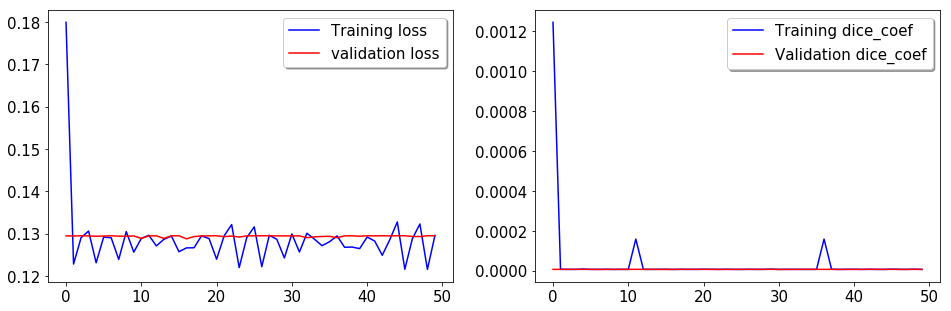

In [0]:
# Plot
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(hist_df['loss'], color='b', label="Training loss")
ax[0].plot(hist_df['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist_df['dice_coef'], color='b', label="Training dice_coef")
ax[1].plot(hist_df['val_dice_coef'], color='r',label="Validation dice_coef")
legend = ax[1].legend(loc='best', shadow=True)

In [0]:
# Save history (for next Resume)
hist_df.to_csv("DefectDetection_history.csv", index=False)

## Part 4: Test data Prediction

In [0]:
# Load the weights that had the best score for predict
#if NoTRAIN == False or RESUME:
model.load_weights("DefectDetection.h5")

In [0]:
# Binarize the mask output by NN
def binarize(masks, th = 0.5):
    # Maximum value of each channel per pixel
    mask_max = np.zeros_like(masks[:,:,0])
    mask_max = np.fmax(masks[:,:,0],masks[:,:,1])
    mask_max = np.fmax(mask_max,masks[:,:,2])
    mask_max = np.fmax(mask_max,masks[:,:,3])
    # Remove non-maximum pixels
    m = np.zeros_like(masks)
    for ch in range(4):
        m[:,:,ch] = (masks[:,:,ch] == mask_max) * masks[:,:,ch]
    # Binarization
    m = (m>th) * 1
    return m

In [0]:
def show_predict_img(df, row):
    if df == "train_df":
        name = train_df.iloc[row].name
        img = cv2.imread(os.path.join(DIRtrain, name),
                             cv2.IMREAD_GRAYSCALE)
    else:
        if df == "submit_df":
            name = test_df.iloc[row//4,0].split('_')[0]
        elif df == "test_df":
            name = test_df.iloc[row,0]
        img = cv2.imread(os.path.join(DIRtest, name),
                             cv2.IMREAD_GRAYSCALE)

    img_ = img[..., np.newaxis]    # Add channel axis
    img_ = img_[np.newaxis, ...]    # Add batch axis
    img_ = img_ / 255.              # 0～1

    pred_masks = model.predict(img_)
    bin_masks = binarize(pred_masks[0, ...], 0.5)

    fig, axs = plt.subplots(5,2, figsize=(12, 6))
    axs[0,0].imshow(img)
    axs[0,0].axis('off')
    axs[0,0].set_title(name)
    axs[0,1].axis('off')
    axs[0,1].set_title("after binarize")
    for i in range(4):
        axs[i+1,0].imshow(pred_masks[0,:,:,i])
        axs[i+1,0].axis('off')
        axs[i+1,0].set_title('class '+ str(i+1))
        axs[i+1,1].imshow(bin_masks[:,:,i])
        axs[i+1,1].axis('off')
        axs[i+1,1].set_title('class '+ str(i+1))

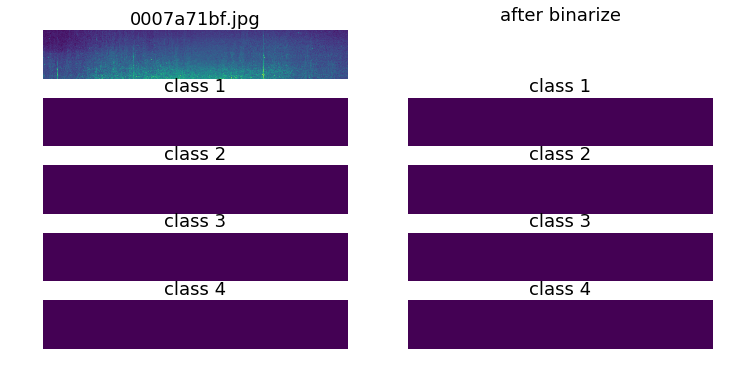

In [0]:
# predict sumple
show_predict_img("train_df", 4)

## Part 5: Kaggle Submission

### Sample

In [0]:
from tqdm import tqdm

In [0]:
submit_df = pd.read_csv("/content/sample_submission.csv")
submit_df['EncodedPixels'] = np.nan
submit_df.head(5)

,ImageId_ClassId,EncodedPixels
0,004f40c73.jpg_1,NaN
1,004f40c73.jpg_2,NaN
2,004f40c73.jpg_3,NaN
3,004f40c73.jpg_4,NaN
4,006f39c41.jpg_1,NaN


### Submission

In [0]:
temp_df = pd.DataFrame()
temp_df['ImageId'] = submit_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
test_df = pd.DataFrame(temp_df['ImageId'].unique(), columns=['ImageId'])
test_df.head()

,ImageId
0,004f40c73.jpg
1,006f39c41.jpg
2,00b7fb703.jpg
3,00bbcd9af.jpg
4,0108ce457.jpg


In [0]:
def mask2rle(mask):
    pixels= mask.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[:-1:2]
    return ' '.join(str(x) for x in runs)

In [0]:
def build_rles(masks):
    width, height, depth = masks.shape
    masks = binarize(masks, th = 0.5)
    rles = [mask2rle(masks[:, :, i]) for i in range(depth)]

    return rles

In [0]:
# Predict test images
for i, line in tqdm(test_df.iterrows()):
    img = cv2.imread(os.path.join(DIRtest, line['ImageId']),
                     cv2.IMREAD_GRAYSCALE)
    img = img[..., np.newaxis]    # Add channel axis
    img = img[np.newaxis, ...]    # Add butch axis
    img = img / 255.              # 0～1
    pred_masks = model.predict(img)[0]
    rles = build_rles(pred_masks)
    for j in range(4):
        if len(rles[j])>0:
            submit_df.iloc[i*4+j,1] = rles[j]

1801it [02:00, 15.01it/s]


In [0]:
submit_df.head(30)

,ImageId_ClassId,EncodedPixels
0,004f40c73.jpg_1,NaN
1,004f40c73.jpg_2,256 1
2,004f40c73.jpg_3,NaN
3,004f40c73.jpg_4,256 1
4,006f39c41.jpg_1,NaN
5,006f39c41.jpg_2,256 1
6,006f39c41.jpg_3,NaN
7,006f39c41.jpg_4,256 1
8,00b7fb703.jpg_1,NaN
9,00b7fb703.jpg_2,256 1


In [0]:
# Number of Defect Detection
submit_df['EncodedPixels'].count()

3602

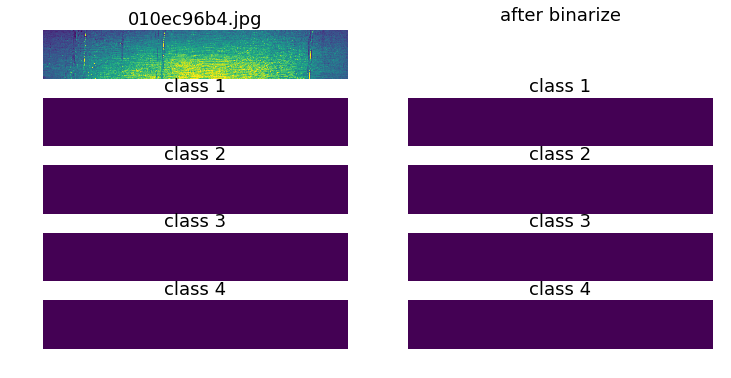

In [0]:
# Detected sumple
show_predict_img("submit_df",26)

In [0]:
submit_df.to_csv('submission.csv', index=False)

### Useful reference:
URL_1 = "https://www.kaggle.com/amanooo/defect-detection-starter-u-net"